In [149]:
#импорт необходимых библиотек
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from statsmodels.stats.proportion import proportions_ztest
from scipy import stats
import os

warnings.filterwarnings('ignore')

----

Представьте, что вы работаете в компании, которая разрабатывает мобильные игры. К вам пришел менеджер с рядом задач по исследованию нескольких аспектов мобильного приложения: 

1. В первую очередь, его интересует показатель retention. Напишите функцию для его подсчета.
2. Помимо этого, в компании провели A/B тестирование наборов акционных предложений. На основе имеющихся данных определите, какой набор можно считать лучшим и на основе каких метрик стоит принять правильное решение.
3. Предложите метрики для оценки результатов последнего прошедшего тематического события в игре.

# Задание 1 

*Посмотрим данные*

## Загрузка данных

Зададим путь к файлам 

In [150]:
#путь к файлам
filepath = 'data/'
print(f'File list in path="{filepath}":\n',*os.listdir(filepath), sep = '\n')

File list in path="data/":

problem1-auth_data.csv
problem1-reg_data.csv
Проект_1_Задание_2.csv


In [151]:
#загружаем
for filename in os.listdir(filepath):
    if not('auth' in filename or 'reg' in filename):
        continue

    if 'auth' in filename:
        auth_data = pd.read_csv(filepath+filename, sep=';')
    if 'reg' in filename:
        reg_data = pd.read_csv(filepath+filename, sep=';')

    print(f'Данные загружены: {filename}')

Данные загружены: problem1-auth_data.csv
Данные загружены: problem1-reg_data.csv


Посмотрим на содержимое датафреймов

In [152]:
auth_data.sample(5)

,auth_ts,uid
2389898,1528148356,233762
8705409,1595750011,1001534
4385140,1559854013,334410
7491031,1587892020,549684
1438655,1501829793,74142


In [153]:
reg_data.sample(5)

,reg_ts,uid
132758,1494778161,147398
404790,1553355002,449384
436976,1557375061,485090
428330,1556325023,475454
227822,1523153129,253051


Видим, что в каждом датафрейме поле <i><u>uid</u></i>-идентификатор пользователя, а  время <i><u>reg_ts</u></i> и <i><u>auth_ts</u></i> представлено в формате Unix timestamp
<br>Посмотрим какой временной интервал покрывают наши данные 

## Перевод даты и времени из Unix timestamp в нормальное отображение времени и даты

In [154]:
#напишим функцию для перевода Unix- timestamp в формат даты
def show_data(df:pd.DataFrame, unit = None):
    """
    Функция для перевода Unix timestamp в формат даты и вывод требуемой части datetime
    Param:
        df: pandas DataFrame
        unit : str|None
            None -> YYYY-MM-dd HH:MM:SS;
            'date' -> YYYY-MM-dd;
            'time' -> HH:MM:SS;
            'year' -> YYYY;
            'month' -> MM;
            'day' -> dd;
            'hour' -> HH;
            'minute' -> MM;
            'second' -> SS;
    """

    unit_format = [None, 'date', 'time', 'year', 'month', 'day', 'hour', 'minute', 'second']

    #проверяем передал ли юзер датафрейм
    if type(df) is not pd.DataFrame:
        return print('Датафрейм не передан')

    #проверим на корректность ввода unix
    if unit not in unit_format:
        return print('Неверный параметр для "unix"')
    

    for k, v in globals().items():
        if v is df:
            df_name = k
            break

    col_name = df_name.split('_')[0] + '_ts'

    #проверим на наличие необходимой колонки в датафрейме
    if col_name not in df.columns:
        print(f'Колонка "{col_name}" отсутствует в датафрейме {df_name}.')
        return
    
    time_min = pd.to_datetime(df[col_name].min(), unit='s')
    time_max = pd.to_datetime(df[col_name].max(), unit='s')
    print(f'Датафрейм {df_name}')

    if unit is None:
        print(f'min {time_min}')
        print(f'max {time_max}')
        return
    
    unit = unit.lower()
    print(f'min {unit} {eval('time_min.'+unit)}')
    print(f'min {unit} {eval('time_max.'+unit)}')
    

In [155]:
# приверим как работает функция
show_data(auth_data, unit='year')
print('---')
show_data(reg_data, unit='year')

Датафрейм auth_data
min year 1998
min year 2020
---
Датафрейм reg_data
min year 1998
min year 2020


Создадим в каждом из датафреймов поле с датой, понятной человеческому восприятию

In [156]:
auth_data['date'] = pd.to_datetime(auth_data.auth_ts, unit='s')
reg_data['date'] = pd.to_datetime(reg_data.reg_ts, unit='s')

In [157]:
def graph_create(list_df:list[pd.DataFrame])->None:
    '''
    Фукнция для построения графиков активных действий пользователей по годам
    Param:
        list_df: список pandas датафреймов
    Return:
        None
    '''

    plt.figure(figsize=(10,5))

    for df in list_df:
        #находим название таблицы
        for column in df.columns:
            if column.endswith('_ts'):
                df_name = column.split('_')[0]

        col_name = df_name + '_count_by_year'
        temp_df = df.copy(deep=True)

        #выделяем из даты год
        temp_df['year'] = temp_df.date.dt.year
        temp_df = temp_df.groupby(['year'])\
                         .agg(cnt=('uid','count'))\
                         .rename(columns={'cnt':col_name})\
                         .reset_index()

        plt.subplot(121)
        plt.barh(temp_df['year'],\
                 width=temp_df[col_name],\
                 label = df_name)
        plt.ylabel('Год')
        plt.yticks(temp_df.year)
        plt.xlabel('Количество')
        plt.legend(loc='lower right')

        #рисуем график в логарифмическом масштабе
        plt.subplot(122)
        plt.barh(temp_df['year'],\
                 width=temp_df[col_name],\
                 label = df_name)
        plt.xscale('log')
        plt.yticks(temp_df.year)
        plt.ylabel('Год')
        plt.xlabel('Количество/log')
        plt.legend(loc='lower right')

    plt.suptitle('Количество активных действий по годам')


## Дейсвтия пользователей по годам 

Посмотрим на распределение количества действий пользователей по годам

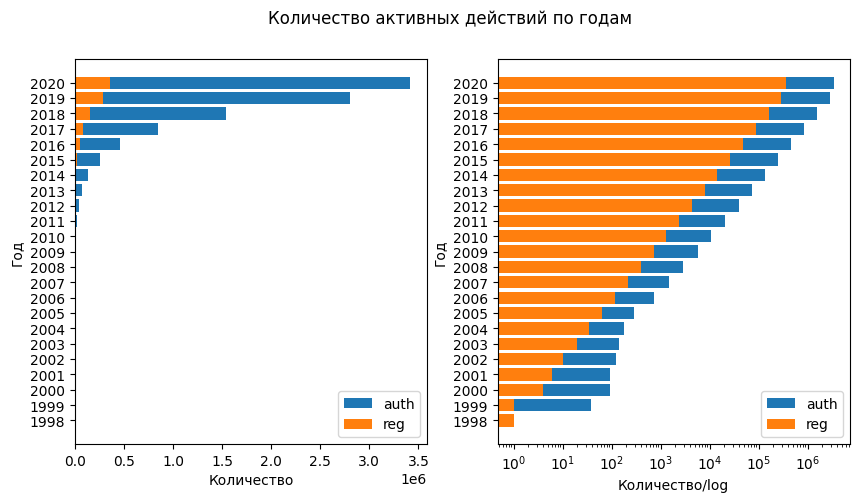

In [158]:
graph_create([auth_data, reg_data])

Видно, что рост регистраций и активность пользователей в игре из года в год происходит по экспоненциальному закону.

## Проверка размеров Дф, типов данных, наличие дубликатов, NAN значений 

#### Размер датафреймов

In [159]:
print(f'Размер датафреймов:\nauth_data {auth_data.shape},\nreg_data {reg_data.shape}', end = '\n\n')

Размер датафреймов:
auth_data (9601013, 3),
reg_data (1000000, 3)



#### Проверим на наличие дубликатов

In [160]:
print('В ДФ auth_data, дибликаты ', 'отсутствуют' if auth_data.duplicated().sum() == 0 else 'имеются')

В ДФ auth_data, дибликаты  отсутствуют


In [161]:
print('В ДФ reg_data, дибликаты ', 'отсутствуют' if reg_data.duplicated().sum() == 0 else 'имеются')

В ДФ reg_data, дибликаты  отсутствуют


#### Типы данных колонок в датафреймах 

In [162]:
print(f'Тип данных полей в датафреймe: auth_data')
auth_data.dtypes

Тип данных полей в датафреймe: auth_data


auth_ts             int64
uid                 int64
date       datetime64[ns]
dtype: object

In [163]:
print(f'Тип данных полей в датафрейме: reg_data')
reg_data.dtypes

Тип данных полей в датафрейме: reg_data


reg_ts             int64
uid                int64
date      datetime64[ns]
dtype: object

#### NaN Значения 

In [164]:
print(f'Количество значений NaN:\nдатафрейм auth_data\n{auth_data.isna().sum()}\n---\nдатафрейм reg_data\n{reg_data.isna().sum()}')

Количество значений NaN:
датафрейм auth_data
auth_ts    0
uid        0
date       0
dtype: int64
---
датафрейм reg_data
reg_ts    0
uid       0
date      0
dtype: int64


В датафрейме <u>reg_data</u> содержаться данные о регистрации пользователей, следовательно поле <u>uid</u> должно быть уникально. Проверим это.

In [165]:
print(f'{'Все пользователи уникальные' if reg_data.uid.nunique() == reg_data.shape[0] else 'Не все пользователи уникальны'}')

Все пользователи уникальные


## Вывод по предворительному анализу данных в датафреймах

* Все значения представлены в типе данных int64
* Размер датафреймов различный
	* auth_data (9601013, 2),
	* reg_data (1000000, 2), что не удивительно, ведь действий (вход в игру) больше, чем регистраций 
* Время в датафреймах в виде Unix timestamp. Данные покрывают временной диапазон с 1998 по 2020 года
* Пропущенных значений нет
* Дубликатов данных нет

---

In [166]:
auth_data.head()

,auth_ts,uid,date
0,911382223,1,1998-11-18 09:43:43
1,932683089,2,1999-07-22 22:38:09
2,932921206,2,1999-07-25 16:46:46
3,933393015,2,1999-07-31 03:50:15
4,933875379,2,1999-08-05 17:49:39


 ## Решение: Задание
 *В первую очередь, его интересует показатель retention. Напишите функцию для его подсчета.*
 <br>**Retention** – один из самых важных показателей в компании. <br>Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока).

### Напишем функцию для *Retention*

In [167]:
def retention_calc(
                reg_df:pd.DataFrame,
                auth_df:pd.DataFrame,
                start_date:pd.Timestamp = None,
                day_count:int = 7,
				return_df:bool = True)->pd.DataFrame:
	'''
		Функция для рассчета retantion rate
		Param:
			reg_df (pd.DataFrame): датафрейм с информацией о регистрации пользователей
			-uid-идентификатор пользователя)
			-reg_ts - Unix Timestamp дата регистрации
			
			auth_df (pd.DataFrame): датафрейм с информацией о активности пользователей
				- uid - Уникальный идентификатор пользователя
				- date - дата в формате Unix Timestamp
			
			start_date (pd.Timestamp, опционально): Дата начала для расчета Retention
			
			day_count (int): Количество дней для вычисления Retention
			
			return_df (bool): флаг, указывающей необходимол ли возвращать итоговый датафрейм
		
		Return:
			pd.DataFrame (опционально): итоговый датафрейм
			plt.Figure: тепловая карта (Heatmap) с визуализацией Retention
	'''
	#проверим переданы ли датафреймы
	if not(isinstance(reg_df, pd.DataFrame) and isinstance(auth_df, pd.DataFrame)):
		print('Не верный формат датафреймов')
		return

	#проверим чтобы передано было число в параметре day_count
	if not isinstance(day_count, int):
		print('Не верный формат day_count, установлено значение по умолчанию (day_count=7)')
		day_count = 7

	#если дата начала не передана,то берем максимальную дату и отнимаем от нее day_count
	if start_date is None:
		start_date = reg_df.date.max()
		end_date = start_date - pd.Timedelta(days=day_count)
		start_date, end_date = end_date, start_date

	#если дата передана в формате Unix Timestamp или в формате строки '2020-02-28'
	#(float нужен для того, чтобы не ловить ошибку если получаем дату функцией pd.Timestamp('2020-02-28').timestamp() которая возвращает значение 1582848000.0 (float))
	if isinstance(start_date, (int, float, str)):
		if isinstance(start_date, (int, float)):
			start_date = pd.to_datetime(start_date, unit='s')
			#проверим переданное значение,что оно лежит в допустимом интервале дат
			if start_date >= reg_df.date.max():
				start_date = reg_df.date.max() - pd.Timedelta(days=day_count)
				end_date = reg_df.date.max()
			else:
				end_date = start_date + pd.Timedelta(days=day_count)

		#кроме того, может нам будет удобнее передовать в формате YYYY-MM-DD HH:MM:SS
		elif isinstance(start_date, str):
			start_date = pd.to_datetime(start_date)
			#проверим переданное значение даты
			if start_date >= reg_df.date.max():
				start_date = reg_df.date.max() - pd.Timedelta(days=day_count)
				end_date = reg_df.date.max()
			else:
				end_date = start_date + pd.Timedelta(days=day_count)

	#для исключения изменений основных датафреймов (мы передаем ссылку на объект), необходимо сделать глубокую копию
	reg_df = reg_df.copy(deep=True)
	auth_df = auth_df.copy(deep=True)

	#фильтруем данные подходящие под наш интервал времени
	reg_df = reg_df.loc[(reg_df.date >= start_date)&(reg_df.date <= end_date)]
	auth_df = auth_df.loc[(auth_df.date >= start_date)&(auth_df.date <= end_date)]

	reg_df.date= reg_df.date.dt.date
	auth_df.date= auth_df.date.dt.date

	#Делаем merge двух датафреймов и выделаем из полученной таблицы только нужные столбцы
	temp_df = pd.merge(	left=reg_df,
						right=auth_df, 
						on='uid',
						suffixes=['_reg','_auth'],
						how='inner')[['uid','date_reg','date_auth']]
	
	#гурппируем данные по дате регистрации и активности, в полученных группах считаем количество уникальных пользователей
	temp_df = temp_df.groupby(['date_reg','date_auth'])\
					.agg(user_cnt=('uid','nunique'))\
					.reset_index()
	
	#после группировки столбцы date_reg и date_auth теряют тип данных pd.datetime (почему??????), поэтому приходиться делать явное преобразование
	temp_df['date_reg'] = pd.to_datetime(temp_df.date_reg)
	temp_df['date_auth'] = pd.to_datetime(temp_df.date_auth)

	#создаем столбец days в котором будет храниться количество дней прошедших с момента регистрации, до момента активности пользователя
	temp_df['days'] = (temp_df.date_auth - temp_df.date_reg).dt.days

	#разворачиваем таблицу таким образом, чтобы в строках оказались даты регистрации, в столбцах количество прошедших дней, а значениями выступали количество уникальных пользователей
	temp_df = temp_df.pivot_table(	columns ='days', 
									index='date_reg', 
									values='user_cnt').rename_axis('Registration_date')
	
	#считаем ретеншен, это количество уникальных пользователей в поле days деленное на общее количество зарегистрировавшихся людей до этого дня, и сразу режим получившийся датафрейм на необходимое количество дней (day_count)
	retention = temp_df.divide(temp_df.iloc[:,0], axis=0).iloc[:,:day_count+1]

	# убираем первую строку, и убираем NaN значения
	retention = retention.drop(retention.columns[0], axis=1).fillna(0)
	
    #формируем визуализацию
	plt.figure(figsize=(10, 6))
	sns.heatmap(retention, 
				annot=True, 
				fmt=".0%", 
				cmap="Blues", 
				cbar_kws={'label': 'Retention Rate / %'})
	plt.title(f"Retention для периода {start_date.date()}/{(start_date + pd.Timedelta(days = day_count)).date()}")
	plt.yticks(ticks=range(len(retention.index)), labels=retention.index.strftime('%Y-%m-%d'), rotation=0)
	plt.xlabel("Дней с момента регистарции")
	plt.ylabel("День регистрации")
	plt.show()

	if return_df:
		return retention

Проверим написанную функцию

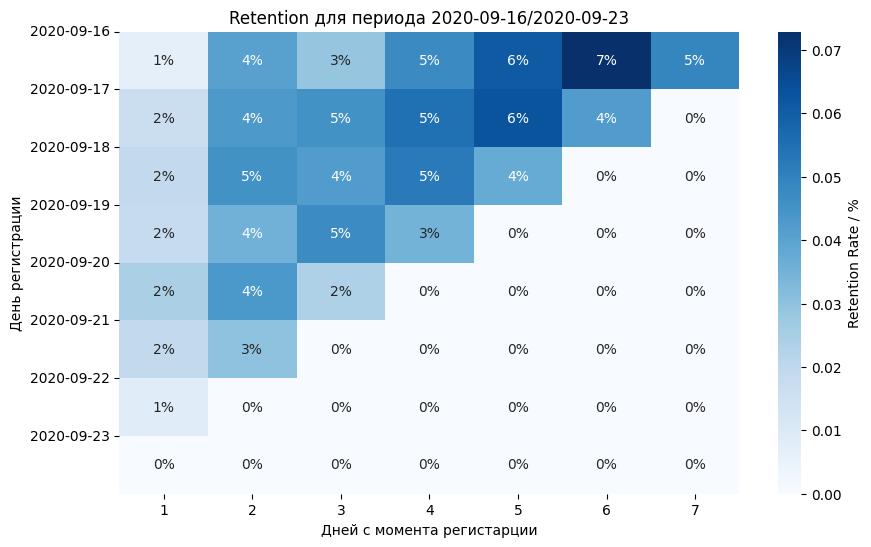

In [ ]:
retention_calc(reg_data, auth_data, return_df=False, day_count=7)

Функция разработана и ее работоспособность проверена

---

# Задание 2
Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений.
Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

## Посмотрим данные

In [169]:
#загрузка данных
task2_df = pd.read_csv('data/Проект_1_Задание_2.csv', sep=';') 
task2_df.sample(5)

,user_id,revenue,testgroup
81683,81684,0,b
110615,110616,0,b
65294,65295,0,b
167213,167214,0,a
307094,307095,0,b


#### Размер датафрейма

In [170]:
task2_df.shape

(404770, 3)

#### Посмотрим тип данных и пропуски

In [171]:
print('Колонка\t\tТипы данных\tПропуски')
for column in task2_df.columns:
    has_missing = 'Нет' if task2_df[column].isna().sum()==0 else 'Да'
    print(f'{column:<20} {str(task2_df[column].dtype):<15} {has_missing:<10}')

Колонка		Типы данных	Пропуски
user_id              int64           Нет       
revenue              int64           Нет       
testgroup            object          Нет       


#### Посмотрим все ли пользователи уникальные

In [172]:
print('Все пользователи уникальные' if task2_df.user_id.nunique()==task2_df.shape[0] else 'Не все пользователи уникальные')

Все пользователи уникальные


#### Проверим есть ли дубликаты

In [173]:
print('В ДФ task2_df, дибликаты ', 'отсутствуют' if task2_df.duplicated().sum() == 0 else 'имеются')

В ДФ task2_df, дибликаты  отсутствуют


#### Посмотрим количество пользователей в разных группах **a** и **b**

In [174]:
task2_df.groupby(['testgroup']).agg(user_cnt=('user_id','nunique'))

,user_cnt
testgroup,
a,202103
b,202667


#### Посмотрим число платящих пользователей, min, max, mean, median оплаты 

In [175]:
# выберем всех пользователей вне зависимости от группы, которые совершали оплату
temp = task2_df.revenue.loc[task2_df.revenue != 0]
print('Число платящих пользоватлей: ',temp.count())
print(f'Минимальная {temp.min()}, максимальная плата {temp.max()}')
print(f'Средняя оплата (mean) {round(temp.mean(),1)}, медианная оплата (median) {temp.median()}')

del temp

Число платящих пользоватлей:  3733
Минимальная 200, максимальная плата 37433
Средняя оплата (mean) 2828.2, медианная оплата (median) 2052.0


#### Распределение revenue по группам

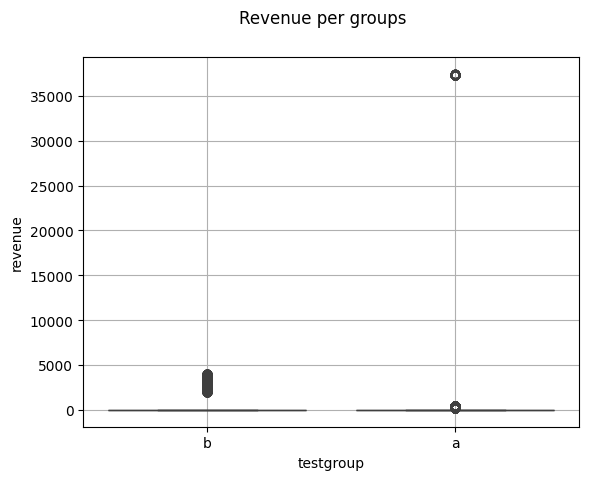

In [176]:
#построим распределение revenue от групп
plt.suptitle('Revenue per groups')
sns.boxplot(data=task2_df, x='testgroup', y='revenue')
plt.grid()
plt.show()

В группе *a* наблюдаются пользователи, которые платят более 30000, что сильно вывбивается из общей картины

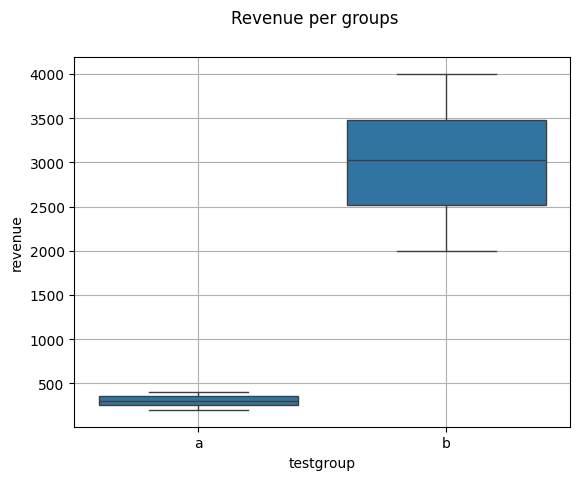

In [177]:
#построим boxplot исключив пользователей с аномально большим значением revenue в группе a
#а также, исключим всех пользоватлей кто не платил, так как из-за них, весь boxplot смещен к 0
plt.suptitle('Revenue per groups')
sns.boxplot(data=task2_df.loc[(task2_df.revenue<35000)&(task2_df.revenue != 0)], x='testgroup',y='revenue')
plt.grid()
plt.show()

Посмотрим сколько пользователей платят более 30000

In [178]:
print('Количество данных с revenue > 30000: ', task2_df.query('revenue>30000').shape[0])

Количество данных с revenue > 30000:  123


Посмотрим распределение пользователей из группы *a* с revenue более 30000

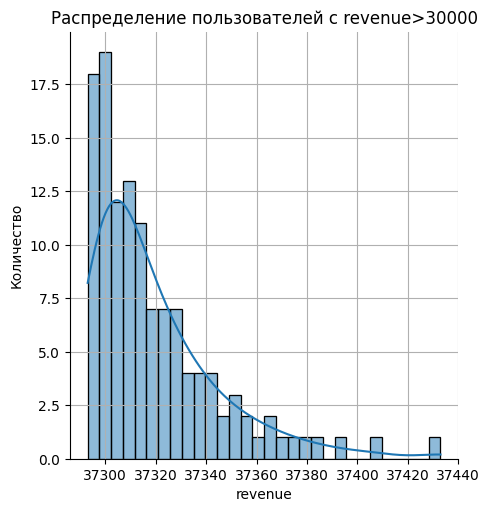

In [179]:
sns.displot(data=task2_df.query('testgroup=="a" and revenue>30000'), x='revenue', bins=30, kde=True)
plt.grid()
plt.title('Распределение пользователей с revenue>30000')
plt.ylabel('Количество')
plt.show()

Посмотрим какую часть выручки делают эти пользователи

In [180]:
print('Пользователи с revenue > 30000 делают ',round(task2_df.query('revenue > 30000 and testgroup=="a"').revenue.sum()/task2_df.query('testgroup=="a"').revenue.sum(), 2)*100, '% от общей выручки группы "a"')

Пользователи с revenue > 30000 делают  89.0 % от общей выручки группы "a"


##### Сделаем описательную статистику для колонки Revenue для разных групп пользователей

In [181]:
#Посмотрим описательную статистику для колонки revenue Для разных групп
print('Revenue a Testgroup')
task2_df.query('testgroup=="a" and revenue<30000 and revenue!=0').revenue.describe()

Revenue a Testgroup


count    1805.000000
mean      302.458172
std        57.914246
min       200.000000
25%       254.000000
50%       305.000000
75%       352.000000
max       400.000000
Name: revenue, dtype: float64

In [182]:
print('Revenue b Testgroup')
task2_df.query('testgroup=="b" and revenue!=0').revenue.describe()

Revenue b Testgroup


count    1805.000000
mean     3003.658172
std       572.619709
min      2000.000000
25%      2513.000000
50%      3022.000000
75%      3478.000000
max      4000.000000
Name: revenue, dtype: float64

##### Распределение Revenue 

Распределение revenue в группе *a*

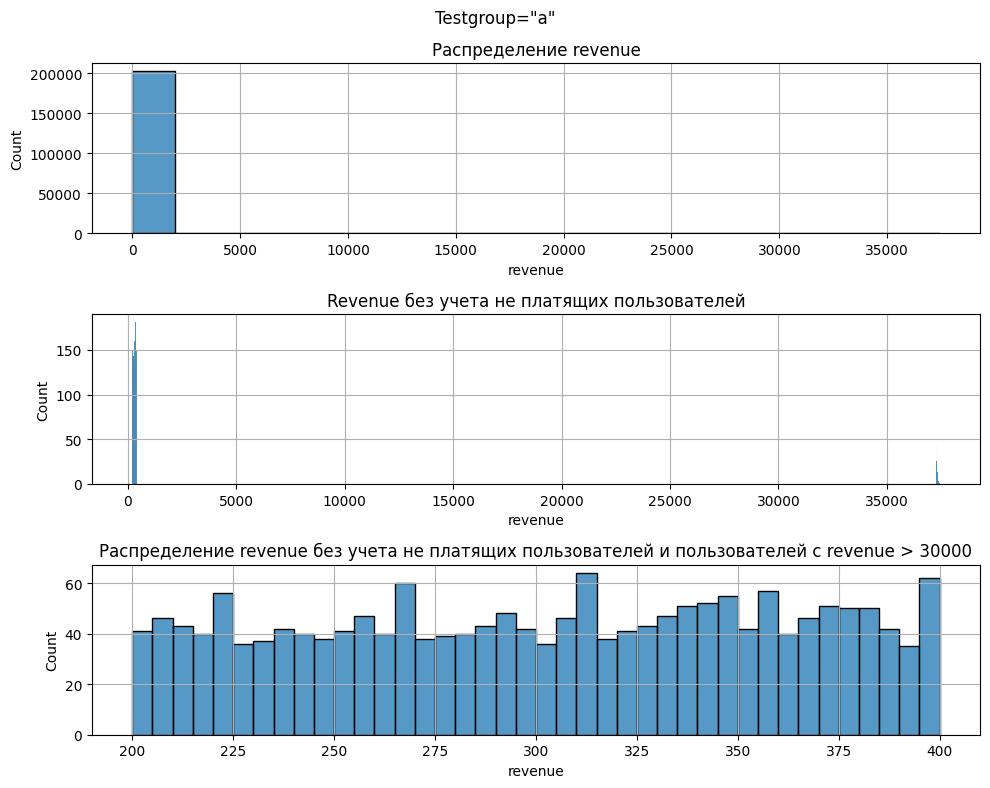

In [183]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10,8))
plt.suptitle('Testgroup="a"')

sns.histplot(data=task2_df.query('testgroup=="a"'), x='revenue', ax=ax1)
ax1.set_title('Распределение revenue')
# ax1.
ax1.grid(True)

sns.histplot(data=task2_df.query('testgroup=="a" and revenue > 0'), x='revenue', ax=ax2)
ax2.set_title('Revenue без учета не платящих пользователей')
ax2.grid(True)

sns.histplot(data=task2_df.query('testgroup=="a" and (revenue > 0 and revenue < 30000)'), x='revenue', ax=ax3, bins=40)
ax3.set_title('Распределение revenue без учета не платящих пользователей и пользователей с revenue > 30000')
ax3.grid(True)

plt.tight_layout()

Распределение revenue в группе *b*

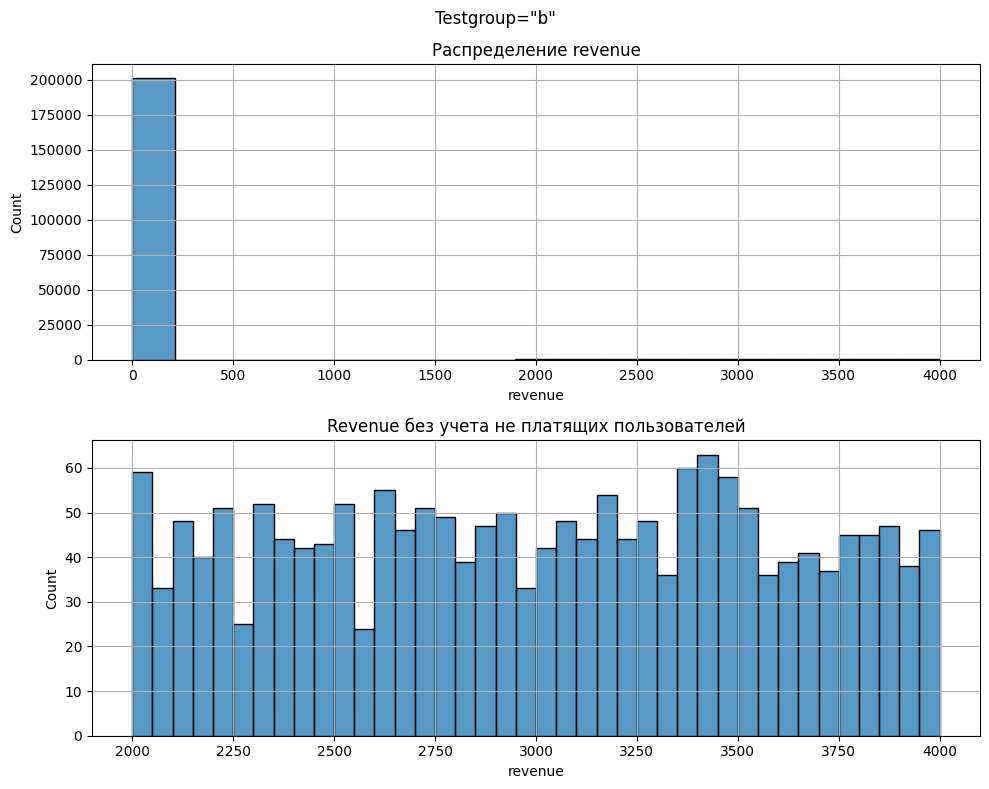

In [184]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,8))
plt.suptitle('Testgroup="b"')

sns.histplot(data=task2_df.query('testgroup=="b"'), x='revenue', ax=ax1)
ax1.set_title('Распределение revenue')
# ax1.
ax1.grid(True)

sns.histplot(data=task2_df.query('testgroup=="b" and revenue > 0'), x='revenue', ax=ax2, bins=40)
ax2.set_title('Revenue без учета не платящих пользователей')
ax2.grid(True)

plt.tight_layout()

### Выводы по предварительному анализу датафрейма 

* Датафрейм состоит из 3 столбцов: 	*user_id*, *revenue*, *testgroup*
* Размер датафрейма *404770 и 3*, строк и столбцов соответственно 
* Типы данных: **user_id** - *int64*, **revenue** - *int64*, **testgroup** - *object*
* Пропущенные значения (NaN) отсутствуют
* Все пользователи (**user_id**) являются уникальными
* Дубликаты отсутствуют
* Колонка **testgroup** содержит буквенное обозначение группы (*a*,*b*) в которую пользователь входит. 
* Количество пользоватлей в группе: 
	* **a** - 202103
	* **b** - 202667
* Из всего набора данных только *3733* пользователя совершали покупки
* Минимальная покупка - 200, максимальная - *37433*
* Среднее значение (mean): *2828.2*
* Медианное значение(median, 50%): *2052*
* Из графика boxplot видно, что размер **revenue** в группе *b* выросло существенно. В группе **а** **revenue** не превышает 500 (min=200, max=400), в то время как в групе *b* revenue лежит в диапазоне от min=2000 до max=4000. 
* Среднее значение группы **a** (после исключения сильно отклоняющихся значений) Xmean=302, группы b Xmean=3003. 
* Медианное **a** - 305, **b** - 3022 (различие на порядок!!!!)
* стандартное отклонение: **a** - std = 57.9, **b** - std = 572.6
* В группе **a** наблюдаются 123 значения (более 30000), значитально отклоняющиеся от остальных

---

## Переходим к решению задачи

Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. 
<br>При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.
Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?</div>
<br>
<br>Для того чтобы принять правильное решение посчитаем следующие метрика для каждой из групп (тестовой и контрольной):
<ul>
<li><i>ARPU</i> (хоть и по условию эта метрика дана, лучше перес читать)</li>
<li><i>ARPPU</i> (средний доход на платящих пользователей)</li>
<li><i>CR</i> конверсия пользователей в платящих пользователей</li>
</ul>

Так как на протяжение решения задачи нам часто придется принимать решения на основе *p_value*, имеет смысл сделать функцию, которая будет нам говорить о том, *p_value* больше уровня значимости или нет

In [185]:
def p_value_meaning(p_value:float, alpha:float = 0.05)->None:
    """
    Фукнция для интерпретации p_value значения
	Функция сравнивает p-значение с уровнем значимости α = 0.05 и выводит решение:
	- Если p_value > 0.05: недостаточно оснований для отклонения H0.
	- Если p_value <= 0.05: отклонение H0 в пользу альтернативной гипотезы (H1).
    Paran:
		p_value (float): значение p_value в результате стат. теста
        alpha (float) = 0.05 значение уровня значимости, по умолчанию 0.05
    Return:
		None: фукнция выводит на экран результат
	"""

    print(f'Нет оснований отклонить H0' if p_value > alpha else 'Отклоняем H0, принимаем гипотезу H1')
    print(f'p_value = {p_value}.')

### **ARPU** (Average revenue per user) - средняя выручка на одного пользователя

In [186]:
#расчитаем среднее arpu по всему датафрейму
total_arpu = task2_df.revenue.sum()/task2_df.user_id.nunique()
print('ARPU всего датафрейма',round(total_arpu,2))

#разобъем наших пользоватлей на две группы (a,b)
group_a = task2_df.query('testgroup=="a"')
group_b = task2_df.query('testgroup=="b"')

#посчитаем ARPU для каждой из групп SUM(revenue)/COUNT(user)
group_a_arpu = round(group_a.revenue.sum()/group_a.user_id.nunique(),2)
group_b_arpu = round(group_b.revenue.sum()/group_b.user_id.nunique(),2)
print(f'ARPU групп пользователей (a,b):\na - {group_a_arpu}\nb - {group_b_arpu}')

#посмотрим разницу между ARPU групп в процентах
print('Разница между ARPU групп a и b в абсолютных значениях составляет: ', round(group_b_arpu-group_a_arpu, 2))
print('Разница между ARPU групп a и b составляет:', round((group_b_arpu*100/group_a_arpu) - 100,2),'%')


ARPU всего датафрейма 26.08
ARPU групп пользователей (a,b):
a - 25.41
b - 26.75
Разница между ARPU групп a и b в абсолютных значениях составляет:  1.34
Разница между ARPU групп a и b составляет: 5.27 %


Действительно разница между ARPU групп составляет &approx; 5%. Значит группа <i>b</i> - тестовая, а  группа <i>а</i> - контрольная.

In [187]:
#переименуем наши датафреймы чтобы не путаться
gcontrol = group_a
gtest = group_b	
gtest.head(2)

,user_id,revenue,testgroup
0,1,0,b
3,4,0,b


In [188]:
#создам датафрейм в который буду добавлять все необходимые данные по каждой из групп
info_df = pd.DataFrame(data=[group_a_arpu, group_b_arpu], columns=['ARPU'], index=['control', 'test'])

#добавим Revenue для каждой группы
info_df['revenue'] = gcontrol.revenue.sum(), gtest.revenue.sum()

#добавлю общее число пользователей в группах
info_df['user_cnt'] = gcontrol.user_id.nunique(), gtest.user_id.nunique()

#добавим число платящих пользователей
info_df['paied_users'] = gcontrol.user_id.loc[gcontrol.revenue != 0].nunique(), gtest.user_id.loc[gtest .revenue != 0].nunique()

#рассчитаем CR (проценты)
info_df['CR_per'] = info_df.paied_users/info_df.user_cnt*100

#расчитаем ARPPU
info_df['ARPPU'] = info_df.revenue/info_df.paied_users

info_df = info_df[['user_cnt','paied_users','revenue','CR_per','ARPU','ARPPU']]
print(f'''Рост ARPU и ARPPU в тестовой группе
      ARPU:{round(info_df.ARPU.loc['test']/info_df.ARPU.loc['control'] * 100 - 100, 2)}%
      ARPPU:{round(info_df.ARPPU.loc['test']/info_df.ARPPU.loc['control'] * 100 - 100,2)}%''')
info_df

Рост ARPU и ARPPU в тестовой группе
      ARPU:5.27%
      ARPPU:12.75%


,user_cnt,paied_users,revenue,CR_per,ARPU,ARPPU
control,202103,1928,5136189,0.953969,25.41,2663.998444
test,202667,1805,5421603,0.890624,26.75,3003.658172


Так как ARPU предполагает некоторое среднее значение, то имеет смысл использовать t-test. Для этого теста необходимо чтобы данные были или распределены нормально и обладали гомогенностью дисперсии, или имели большое число наблюдений в случае не нормального распределения, а в случае не равенства дисперсий можно использовать t-test с критериев Уэлча. Таким образом, проверка на гомогенность дисперсии и на нормальность не обязательна, однако, в рамках обучающего проекта есть смысл идти по пути проверки всех требований.

#### Проверка на нормальность распределения

Для проверки на нормальное распределение можно использовать тест Шапира-Уилка, однако при больших объемах данных, имеющих явную асимметрию или выбросы, более подходящим является тест Д`Агостина-Пирсона (stats.normaltest)
<br>
Сформулируем гипотезы:
<br>*H0* - данные имеют нормальное распределние
<br>*H1* - данные распределены ненормально
<br> уровень значимости $\alpha$ = 0.05

In [189]:
print('Тестовая группа:')
p_value_meaning(stats.normaltest(gtest.revenue)[1])
print('Контрольная группа:') 
p_value_meaning(stats.normaltest(gcontrol.revenue)[1])

Тестовая группа:
Отклоняем H0, принимаем гипотезу H1
p_value = 0.0.
Контрольная группа:
Отклоняем H0, принимаем гипотезу H1
p_value = 0.0.


Как и предполагалось из общего вида графиков, <u>данные не имеют нормального распределения</u>, однако, как говорилось ранее, нам это и не обязательно 

#### Проверка на гомогенность дисперсии (тест Левена)

Сформулируем гипотезы:
<br>*H0* - дисперсия в тестовой и контрольной группах равны
<br>*H1* - дисперсии не равны
<br> уровень значимости $\alpha$ = 0.05

In [190]:
p_value_meaning(stats.levene(gcontrol.revenue, gtest.revenue)[1])

Нет оснований отклонить H0
p_value = 0.5324948591043842.


В группах a и b по результатам теста Леневе <u>Дисперсии равны</u>.

#### Проверка на стат. значимые различия ARPU в двух группах a и b

Для проверки будем использовать t-тест (stats.ttest_ind) для двух независимых выборок.
<br>Сформулируем гипотезы:
<br>*H0* - среднии значения двух групп revenue принадлежат одной генеральной совокупности (между ARPU двух групп нет стат. значимого различия)
<br>*H1* - между средними значениями revenue двух групп имеется стат. значимое различие

In [191]:
p_value_meaning(stats.ttest_ind(gtest.revenue, gcontrol.revenue)[1])

Нет оснований отклонить H0
p_value = 0.532494858971837.


**Вывод по ARPU**
По результатам проведенного t-теста, <u>статистически значимого различия</u> между ARPU тестовой и контрольной групп <u>не выявлено</u>. Оставляем нулевую гипотезу.  

---

### **ARPPU** (average revenue per paying users) - средняя выручка на платящего пользователя

ARPPU похожа на ARPU и для этого критерия подходят все те же выводы, что и для ARPU, с тем лишь отличием, что будут в расчет браться не все пользователи, а лишь те, которые оплачивают.
Проведем такие же тесты: проверим на нормальность (Д`Агостина-Пирсона), равенство дисперсий (тест Ленева) и сравним полученные ARPPU двух групп с помощью t-теста.

In [192]:
print('Изменение ARPPU в тестовой группе относительно контрольной в в абсолютных значениях: ', round(info_df.ARPPU.loc['test'] - info_df.ARPPU.loc['control'],2))
print('Изменение ARPPU в тествоой группе относительно контрольной группы составляет: ', round(info_df.ARPPU.loc['test']/info_df.ARPPU.loc['control'] * 100 - 100, 2),'%')

Изменение ARPPU в тестовой группе относительно контрольной в в абсолютных значениях:  339.66
Изменение ARPPU в тествоой группе относительно контрольной группы составляет:  12.75 %


#### Проверка на нормальность распределения

тест Д`Агостина-Пирсона (stats.normaltest)
<br>
Сформулируем гипотезы:
<br>*H0* - данные имеют нормальное распределние
<br>*H1* - данные распределены ненормально
<br> уровень значимости $\alpha$ = 0.05

In [193]:
print('Тестовая группа:')
p_value_meaning(stats.normaltest(gtest.query('revenue != 0').revenue)[1])
print('Контрольная группа:') 
p_value_meaning(stats.normaltest(gcontrol.query('revenue != 0').revenue)[1])

Тестовая группа:
Отклоняем H0, принимаем гипотезу H1
p_value = 7.943249488371762e-233.
Контрольная группа:
Отклоняем H0, принимаем гипотезу H1
p_value = 1.2341605505935488e-303.


Как и в случае c ARPU <u>данные не имеют нормального распределения</u>.  

#### Проверка на гомогенность дисперсии (тест Левена)

Сформулируем гипотезы:
<br>*H0* - дисперсия в тестовой и контрольной группах равны
<br>*H1* - дисперсии не равны
<br> уровень значимости $\alpha$ = 0.05

In [194]:
p_value_meaning(stats.levene(gcontrol.query('revenue != 0').revenue, gtest.query('revenue != 0').revenue)[1])

Отклоняем H0, принимаем гипотезу H1
p_value = 3.779689868667878e-19.


В группах a и b по результатам теста Леневе <u>Дисперсии не равны</u>.

#### Проверка на стат. значимые различия ARPPU в двух группах control и test

Для проверки будем использовать t-тест (stats.ttest_ind) для двух независимых выборок.
<br>Сформулируем гипотезы:
<br>*H0* - значения ARPPU двух групп принадлежат одной генеральной совокупности (между ARPPU двух групп нет стат. значимого различия)
<br>*H1* - значениe ARPPU тестовой и контрольной групп имеется стат. значимое различие

In [195]:
p_value_meaning(stats.ttest_ind(gtest.query('revenue != 0').revenue, gcontrol.query('revenue != 0').revenue)[1])

Нет оснований отклонить H0
p_value = 0.11153459157259497.


**Вывод по ARPPU**
<br>По результатам проведенного t-теста, <u>статистически значимого различия</u> между ARPPU тестовой и контрольной групп <u>не выявлено</u>. Оставляем нулевую гипотезу.  

---

### **CR** (conversion rate) - доля пользователей выполнивших целевую метрику, в нашем случае, оплата

In [196]:
info_df

,user_cnt,paied_users,revenue,CR_per,ARPU,ARPPU
control,202103,1928,5136189,0.953969,25.41,2663.998444
test,202667,1805,5421603,0.890624,26.75,3003.658172


Давайте посмотрим на таблицу info_df:
<br>Посмотрим на сколько уменьшилась конверсия в тестовой группе, и имеет ли это изменение стат. значение

Для определения стат. значения изменения конверсии можно использовать тест Пирсона (Хи-квадрат). Для этого необходимо немного поработать с данными

In [197]:
chi_df = task2_df.copy(deep=True)
chi_df['converted'] = chi_df.revenue > 0

#сформируем таблицу-сопряженности для chi-square
chi_df = chi_df.groupby(['testgroup', 'converted'], as_index=False) \
    .agg(user_cnt=('user_id','count')) \
	.pivot(index='converted',columns='testgroup', values='user_cnt')
chi_df

testgroup,a,b
converted,,
False,200175,200862
True,1928,1805


Сформулируем гипотезу:
<br>*H0* - категориальные переменные (*a*, *b*) независимы, т.е. не имеют статистически значимой связи
<br>*H1* - переменные зависимы
<br>Уровень значимости $\alpha = 0.05$

In [198]:
#используем функцию из пакета scipy.stats.chi2_contingency - тест независимости переменных в таблице сопряженности
p_value = stats.chi2_contingency(chi_df)[1]
p_value_meaning(p_value)

Отклоняем H0, принимаем гипотезу H1
p_value = 0.03647561892312613.


По результатам теста хи-квадрат, видно, что изменение конверсии в тестовой и контрольных групп имеет стат. значимое различие. 

Найдем разницу в конверсиях:

In [199]:
round(info_df.CR_per.loc['control']-info_df.CR_per.loc['test'], 3)

np.float64(0.063)

**Вывод по CR**<br >
По результатам теста, видим, что p_value < alpha (0.05) следовательно, мы отклоняем гипотезу H0 о том, что категориальные переменные независимы, другими словами, уменьшение конверсии тестовой группы на 0.063 относительно тестовой группы <u>имеет стат. значимые различия</u>

---

## Выводы по A\B тесту

По результатам A\B тесту можно сказать, что конверсия в тестовой группе уменьшилась, ARPU и ARPPU  увеличилось, но это изменение не имеет стат. значимого значения. Таким образом, можно сказать, что лучшем решением является **оставить текущее предложени**. Тестовое предложение по результатам A\B тестирования провалилось.

---

--- 

## Предположим...

Однако, мы видим, что в группе *a* есть какие то странные 123 пользователя доход с которых составляет 89% от общего дохода группы. Давайте предположим, что в процессе подготовки данных возникла ошибка и в набор контрольной группы попали люди, которые покупают по каким то другим условиям, в отличии от всех остальных пользоватлей в этой группе.
<br>Попробуем удалить этих пользоватлей как случайно попавших, и сравним еще раз ARPU, ARPPU и CR

In [200]:
test_df = task2_df.query('revenue < 30000')

In [201]:
#расчитаем среднее arpu по всему датафрейму
total_arpu = test_df.revenue.sum()/task2_df.user_id.nunique()
print('ARPU всего датафрейма',round(total_arpu,2))

#разобъем наших пользоватлей на две группы (a,b)
group_a = test_df.query('testgroup=="a"')
group_b = test_df.query('testgroup=="b"')

#посчитаем ARPU для каждой из групп SUM(revenue)/COUNT(user)
group_a_arpu = round(group_a.revenue.sum()/group_a.user_id.nunique(),2)
group_b_arpu = round(group_b.revenue.sum()/group_b.user_id.nunique(),2)
print(f'ARPU групп пользователей (a,b):\na - {group_a_arpu}\nb - {group_b_arpu}')

#посмотрим разницу между ARPU групп в процентах
print('Разница между ARPU групп a и b в абсолютных значениях составляет: ', round(group_b_arpu-group_a_arpu, 2))
print('Разница между ARPU групп a и b составляет:', round((group_b_arpu*100/group_a_arpu) - 100,2),'%')

ARPU всего датафрейма 14.74
ARPU групп пользователей (a,b):
a - 2.7
b - 26.75
Разница между ARPU групп a и b в абсолютных значениях составляет:  24.05
Разница между ARPU групп a и b составляет: 890.74 %


In [202]:
#переименуем наши датафреймы чтобы не путаться
gcontrol = group_a
gtest = group_b	

In [203]:
#создам датафрейм в который буду добавлять все необходимые данные по каждой из групп
info_df = pd.DataFrame(data=[group_a_arpu, group_b_arpu], columns=['ARPU'], index=['control', 'test'])

#добавим Revenue для каждой группы
info_df['revenue'] = gcontrol.revenue.sum(), gtest.revenue.sum()

#добавлю общее число пользователей в группах
info_df['user_cnt'] = gcontrol.user_id.nunique(), gtest.user_id.nunique()

#добавим число платящих пользователей
info_df['paied_users'] = gcontrol.user_id.loc[gcontrol.revenue != 0].nunique(), gtest.user_id.loc[gtest .revenue != 0].nunique()

#рассчитаем CR (проценты)
info_df['CR_per'] = info_df.paied_users/info_df.user_cnt*100

#расчитаем ARPPU
info_df['ARPPU'] = info_df.revenue/info_df.paied_users

info_df = info_df[['user_cnt','paied_users','revenue','CR_per','ARPU','ARPPU']]
print(f'''Рост ARPU и ARPPU в тестовой группе
      ARPU:{round(info_df.ARPU.loc['test']/info_df.ARPU.loc['control'] * 100 - 100, 2)}%
      ARPPU:{round(info_df.ARPPU.loc['test']/info_df.ARPPU.loc['control'] * 100 - 100,2)}%''')
info_df

Рост ARPU и ARPPU в тестовой группе
      ARPU:890.74%
      ARPPU:893.08%


,user_cnt,paied_users,revenue,CR_per,ARPU,ARPPU
control,201980,1805,545937,0.893653,2.70,302.458172
test,202667,1805,5421603,0.890624,26.75,3003.658172


Теперь получается так, что revenue, ARPU и ARPPU в двух группах различается на порядок! При этом конверсия примерно равна.
Давайте быстренько сравним ARPU, ARPPU и CR, по аналогии с тем, как это было сделано выше, но без проверок.

### **ARPU**

Для проверки будем использовать t-тест (stats.ttest_ind) для двух независимых выборок.
<br>Сформулируем гипотезы:
<br>*H0* - среднии значения двух групп revenue принадлежат одной генеральной совокупности (между ARPU двух групп нет стат. значимого различия)
<br>*H1* - между средними значениями revenue двух групп имеется стат. значимое различие

In [204]:
p_value = stats.ttest_ind(gtest.revenue,gcontrol.revenue)[1]
p_value_meaning(p_value)

Отклоняем H0, принимаем гипотезу H1
p_value = 4.912187544972622e-306.


Наблюдаются стат. значимые различия между ARPU тестовой и контрольной групп

--- 

### **ARPPU**

Для проверки будем использовать t-тест (stats.ttest_ind) для двух независимых выборок.
<br>Сформулируем гипотезы:
<br>*H0* - значения ARPPU двух групп принадлежат одной генеральной совокупности (между ARPPU двух групп нет стат. значимого различия)
<br>*H1* - значениe ARPPU тестовой и контрольной групп имеется стат. значимое различие

In [205]:
p_value_meaning(stats.ttest_ind(gtest.query('revenue != 0').revenue, gcontrol.query('revenue != 0').revenue)[1])

Отклоняем H0, принимаем гипотезу H1
p_value = 0.0.


**Вывод по ARPPU**
<br>По результатам проведенного t-теста, <u>выявлены статистически значимые различия</u> между ARPPU тестовой и контрольной группами. Принимаем альтернативную гипотезу.  

--- 

### **CR**

In [206]:
chi_df = task2_df.copy(deep=True)
chi_df['converted'] = chi_df.revenue > 0

#сформируем таблицу-сопряженности для chi-square
chi_df = chi_df.groupby(['testgroup', 'converted'], as_index=False) \
    .agg(user_cnt=('user_id','count')) \
	.pivot(index='converted',columns='testgroup', values='user_cnt')
chi_df

testgroup,a,b
converted,,
False,200175,200862
True,1928,1805


Сформулируем гипотезу:
<br>*H0* - категориальные переменные (*a*, *b*) независимы, т.е. не имеют статистически значимой связи
<br>*H1* - переменные зависимы
<br>Уровень значимости $\alpha = 0.05$

In [207]:
#используем функцию из пакета scipy.stats.chi2_contingency - тест независимости переменных в таблице сопряженности
p_value = stats.chi2_contingency(chi_df)[1]
p_value_meaning(p_value)

Отклоняем H0, принимаем гипотезу H1
p_value = 0.03647561892312613.


**Вывод по CR**
<br >
По результатам теста, видим, что p_value < alpha (0.05) следовательно, мы отклоняем гипотезу H0 о том, что категориальные переменные независимы, другими словами, уменьшение конверсии тестовой группы на 0.003 относительно тестовой группы <u>имеет стат. значимые различия</u>

---

## Вывод по предположению

Таким образом при удалении из расчетов пользоватлей с оплатами более 30000 получается, что тестовое предложение более предпочтительнее, так как наблюдается увеличение ARPU, ARPPU, CR. НО!!!, такой подход очень рискованный, мы не знаем где имеено появилась ошибка, на этапе сборки информации, или планировании эксперимента. 
<u><br>Считаю, правильным решением является повтор эксперимента!</u>

---

# Задание 3

<br>п. 1 - В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?
<br>п. 2 - Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

<b>п.1</b> 
<ul>
<li>Количество активных пользователей за день, неделю или даже месяц <i>(DAU, WAU, MAU)</i></li>
<li>Также хотелось бы посмотреть на <i>Retention rate</i>. Наблюдается ли рост потока пользоватлей в игру (например: человек не играл, но потом новый event привлек его обратно).</li>
<li>По аналогии с retention rate, нужно попсмотреть процент оттока игроков из игры (<i>Churn rate</i>). Возможно новое событие не нравится игрокам и они активно забрасывают игру. Если мы будем наблюдать активный отток, без заметного притока как новых, так и старых игроков, есть смысл закончить событие раньше намеченного или изменить условия</li>
<li>Среднее время проведенное пользователем в игре (<i>Mean time</i>) до и после события. Можно оценить помогает ли новое событие завлечь внимание пользователя на большее время.</li>
<li>Если в нашей игре присутствует финансовая составляющая (покупка чего бы то не было) нужно посчитать <i>ARPU, ARPPU, CR</i></li>
<li>Так как для получения наград требуется пройти ряд уровней на время, то нужно посмотреть среднее прохождение одного уровня, всех уровней, и каждого в отдельности. Посмотреть на процент пользоватлей справившихся, процент пользоватлей кто пробовал. Оценить коэффициент успешности, возможно, временные рамки для прохождения уровня слишком задраны и следует их подкорректировать. Оценить отток пользоватлей вызванный однократной, многократной неудачей прохождения уровней и т.д.</li>
</ul>
<b>п.2</b>
<ul>
<li>В общем виде набор метрик останется прижним. </li>
<li>Следует добавить обязательное тестирование данных на отток пользователей вызванных откатом прогресса после неудачной попытки. </li>
<li>Посмотреть сколько успешных прохождений до отката. Возможно уровни слишком несбаллансированы из за чего, у игрока падает мотивация.</li>
<li>Оценить процент пользователей успешно завершивших event, к общему числу пользователей.</li>
</ul>